# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Arild Madshaven
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [ ]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

In [ ]:
import skimage.io
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [ ]:
def plotHist(im, dsc=''):
    im_h, im_w = im.shape
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.hist(im)
    ax.set_title(dsc+' ({} px, {} px)'.format(im_h, im_w))
    plt.show()

In [ ]:
def plotIm(im, dsc='', scale=1):
    im_h, im_w = im.shape

    fig, ax = plt.subplots(1, 1, figsize=(6*scale, 6*scale))
    ax.imshow(im, cmap='gray')
    ax.set_title(dsc+' ({} px, {} px)'.format(im_h, im_w))
    ax.axis('off')
    plt.show()

In [ ]:
def plotImComp(im1, im2, dsc='', scale=2):
    plotIm(np.concatenate((im1, im2), axis=1), dsc=dsc, scale=scale)

In [6]:
def thrsh(im, l_thr, u_thr, invert=False):
    trf = im.copy()
    if not invert:
        trf[trf < l_thr] = 0
        trf[u_thr < trf] = 255
    else:
        trf[trf < l_thr] = 255
        trf[u_thr < trf] = 0       
    return trf

In [7]:
def neighbourInRange(lower, upper, neighbour, _):
    return lower < neighbour < upper

In [346]:
def neighbourInRelativeRange(lower, upper, neighbour, current):
    global fn_ran
    fn_ran += 1
    return current-lower < neighbour < current+upper

In [9]:
def stretchHist(im, new_max):
    c = im.copy().astype('float64')
    min_val = c.min()
    max_val = c.max()
        
    c -= min_val
    c /= (max_val - min_val)
    
    return (c * new_max).astype('uint8')

#### First some mild denoising

In [ ]:
d_brain = cv2.GaussianBlur(brain_im, (3,3), 1)
plotImComp(d_brain, brain_im, 'Brain after and before denoising')
plotHist(d_brain, 'Denoised brain histogram')

#### Our brain tissue is light gray. 52 seems like a safe lower threshold to eliminate dark shades of gray.

In [ ]:
l_thr = 45
u_thr = 255
t_brain = thrsh(d_brain, l_thr, u_thr)
plotImComp(t_brain, d_brain, dsc=f'After and before lower threshold at {l_thr}'), 
plotHist(t_brain, f'Brain histogram after lower threshold at {l_thr}')

#### The lightest shades are seemingly found in the skull surrounding the brain. 
Assuming brain tissue is in the 40(52) - 100 bins. Tryin to set the lightest shades to zero, say those above 91

In [ ]:
u_thr = 91
t1_brain = thrsh(t_brain, 0, u_thr, invert=True)
plotImComp(t1_brain, t_brain, f'After removal of pixels>{u_thr} and before')

#### Notice weak edges connecting brain tissue to other stuff in the top. Detach by opening

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,4))
t1o_brain = cv2.morphologyEx(t1_brain, cv2.MORPH_OPEN, kernel)
plotImComp(t1o_brain, brain_im, 'After opening and original image')

#### The brain is a detached connex region. Hooray!

### 1.2 Region growing
Add your implementation and discussion

#### Helper fn. Returns all connex neighbours from one seed

In [10]:
def collectRegion(seed, visited, im_arr, lower_threshold, upper_threshold, fn=neighbourInRange, HIGHEST_PIX_VALUE=255):

    detected = set([seed])
    region = set()

    x_min = y_min = 0
    x_max, y_max = im_arr.shape
    
    while len(detected):
        
        
        pix = detected.pop()
        
        if pix in visited: continue
                
        pix_val = im_arr[pix]
        
        x, y = pix
    
        for xi in range(max(x-1, x_min), min(x+2, x_max), 2):
            if ((xi, y)) in visited: continue
            if fn(lower_threshold, upper_threshold, im_arr[xi, y], pix_val): detected.add((xi, y))
        for yi in range(max(y-1, y_min), min(y+2, y_max), 2):
            if ((x, yi)) in visited: continue
            if fn(lower_threshold, upper_threshold, im_arr[x, yi], pix_val): detected.add((x, yi))
                
        region.add(pix)
        visited.add(pix)
        
    return list(region)

In [340]:
def collectAllRegions(seeds, im, min_region_size, l_thr, u_thr, fn=neighbourInRange):
    
    regions = []
    visited = set()

    for seed in seeds:
        
        if seed in visited: continue
            
        region = collectRegion(seed, visited, im, l_thr, u_thr, fn=fn)
        
        if len(region)>=min_region_size: regions.append(region)
        else: visited -= set(region)
        
    return regions, visited

In [12]:
def idxOfLargestList(lst):
    max_s = max_i = 0
    for i in range(len(lst)):
        size = len(lst[i])
        if size > max_s:
            max_s = size
            max_i = i
    return max_i

In [13]:
def createIndexGrid(image_shape, distance):
    
    indices = set()
    
    for xi in range(image_shape[0]):
        for yi in range(image_shape[1]):
            if not xi%distance and not yi%distance: indices.add((xi, yi))            
    return indices

In [14]:
def visualizeIndices(im, indices, text=''):
    tp = im.copy()
    for i in indices: tp[i] = 255
    plotIm(tp, text)   

In [15]:
## HOPEFULLY DEPRECATED

def identifyLargestRegion(processed_im, original_im, l_thr, u_thr, seeds_grid_d, relative_threshold=False):
    c = processed_im.copy()
    
    # Create grid of seeds. 
    
    seeds = set()

    d = seeds_grid_d
    for xi, row in enumerate(processed_im):
        for yi, val in enumerate(row):
            if not xi%d and not yi%d: seeds.add((xi, yi))  
                
    # Visualize seed pixels
    tp = c.copy()
    for pix in seeds: tp[pix] = 255
    plotIm(tp, f'Grid of seeds with d={d}')
    
    # Fetch all areas from seed points and visualize on original image
    
    regions, visited_pixels = collectAllRegions(seeds, c, l_thr, u_thr, relative_threshold=relative_threshold)
    tp = original_im.copy()
    for p in visited_pixels: tp[p] = 255
    plotIm(tp, 'All connex regions which satisfy criterion')
    
    # Fetch largest region 
    max_ri = idxOfLargestList(regions)
    
    # Visualize largest region
    c = original_im.copy()
    for p in regions[max_ri]: c[p] = 255
    plotImComp(c, original_im, 'Largest region and original image')
    
    # Return list of indices to largest region
    return regions[max_ri]

In [ ]:
l_thr = 1 # Lower pixel value threshold of potential brain tissue
u_thr = 255 # Upper pixel value threshold of potential brain tissue
seed_grid_d = 50 # Sparsity of seed grid

seeds = createIndexGrid(brain_im.shape, seed_grid_d)
visualizeIndices(brain_im, seeds, f'Indices grid distance {seed_grid_d}')

#brain_pixel_indices = identifyLargestRegion(t1o_brain, brain_im, l_thr, u_thr, seed_grid_d)

In [ ]:
u_thr = 7
l_thr = 7
regions, visited_pixels = collectAllRegions(seeds, brain_im, l_thr, u_thr, fn=neighbourInRelativeRange)

In [ ]:
visualizeIndices(brain_im, visited_pixels, f'All regions found with lower, upper threshold = ({l_thr}, {u_thr})')

In [ ]:
print(f"Brain size: {len(brain_pixel_indices)}")

### Steal Theo's solution

In [ ]:
op = np.load('im_open.pkl.npy')
plotIm(op)

#### Identify single seed

In [ ]:
plotIm(op[110:, 110:])

In [ ]:
seed = (110,110)
l_thr = op[seed] - 1
u_thr = op[seed] + 1

In [ ]:
brain_pixels = collectRegion(seed, op, l_thr, u_thr)

In [ ]:
brain_im_cpy = brain_im.copy()
for pix in brain_pixels: brain_im_cpy[pix] = 255
plotImComp(brain_im, brain_im_cpy, 'Original picture and estimated brain tissue colored white')

In [ ]:
print(f"Brain size: {len(brain_pixels)}")

In [ ]:
c = brain_im.copy()
for p in brain_pixel_indices: c[p]= 255

In [ ]:
plotImComp(c, brain_im_cpy, 'First and second sol')

### 1.3 Contour detection
Add your implementation and discussion

#### Remember for discussion: 
[https://en.wikipedia.org/wiki/Edge_detection] The early Marr–Hildreth operator is based on the detection of zero-crossings of the Laplacian operator applied to a Gaussian-smoothed image. It can be shown, however, that this operator will also return false edges corresponding to local minima of the gradient magnitude. Moreover, this operator will give poor localization at curved edges. Hence, this operator is today mainly of historical interest.

In [16]:
def LoG(sigma, x, y):
    return -1/(np.pi * sigma**4)*np.exp(-(x**2+y**2)/(2*sigma**2))*(1 - (x**2+y**2)/(2*sigma**2))

In [17]:
from sklearn.preprocessing import normalize

In [18]:
def constructLoGKernel(sigma, size=7):
    assert size%2, 'Kernel must be odd'
    
    kernel = np.zeros((size,size))
    mid = size//2
    
    for y in range(-mid, mid+1):
        for x in range(-mid, mid+1):
            kernel[x+mid, y+mid] = LoG(sigma,x,y)
            
    kernel = normalize(kernel, axis=1, norm='l1')
    return kernel

In [19]:
def printKernel(k, dsc='',round_val=2):
    print(dsc)
    for row in k:
        for e in row: print(round(e, 2), end='\t')
        print()

#### Stretch histogram a bit to ease contour detection

In [ ]:
b = brain_im.copy()
b = stretchHist(b, 255)

plotImComp(b, brain_im, 'After histogram stretch and before')

#### Apply Laplacian of Gaussian method

In [ ]:
sigma = 2.25 ## Larger sigma = more noise reduction
kernel_size = 9 ## Larger kernel = better approximation
LoG_kernel = constructLoGKernel(sigma, kernel_size)

brain_LoG = cv2.filter2D(b, -1, LoG_kernel) 
plotImComp(brain_im, brain_LoG, 'Original brain and Marr-H contour detection')
printKernel(LoG_kernel, 'Marr-Hildreth kernel')

In [ ]:
unstretched_LoG = cv2.filter2D(brain_im, -1, LoG_kernel) 
plotImComp(brain_LoG, unstretched_LoG, 'Marr-H with and without prior histogram stretch')

#### Filter out weak edges

In [ ]:
l_thr = 56
h_thr = 255
t_brain_LoG = thrsh(brain_LoG, l_thr, h_thr)
plotImComp(brain_LoG, t_brain_LoG, 'Before and after weak edge razor')

#### Do some closing to close edge surrounding brain

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
tc_brain_LoG = cv2.morphologyEx(t_brain_LoG, cv2.MORPH_CLOSE, kernel)
plotImComp(t_brain_LoG, tc_brain_LoG, 'Before and after closing')

#### Set background white and look for dark regions

In [ ]:
seed = (1,1)
bg = collectRegion(seed, b, -1, 40)
for pix in bg: tc_brain_LoG[pix] = 255
plotIm(tc_brain_LoG)

In [ ]:
l_thr = -1
u_thr = 1
seed_grid_distance = 25
brain_contour = identifyLargestRegion(tc_brain_LoG, brain_im, l_thr, u_thr, seed_grid_distance)

In [ ]:
print(f"Size of brain: {len(brain_contour)}")

## Relative difference

In [ ]:
identifyLargestRegion(brain_im, brain_im, 8, 7, 50, relative_threshold=True)

### 1.4 Additional method(s)
Add your implementation and discussion

## Canny edge detection

#### Starting out with the histogram-stretched version

In [ ]:
plotIm(b)

In [ ]:
l_thr = 105
u_thr = 3*l_thr
canny_b = (cv2.Canny(b, l_thr, u_thr))
plotImComp(canny_b, brain_im)

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
c_canny_b = cv2.morphologyEx(canny_b, cv2.MORPH_CLOSE, kernel)
plotImComp(canny_b, c_canny_b, 'Before and after closing')

#### Again, set background white

In [ ]:
seed = (1,1)
bg = collectRegion(seed, c_canny_b, -1, 40)
for pix in bg: c_canny_b[pix] = 255
plotIm(c_canny_b)

#### ... and find the largest black area

In [ ]:
l_thr = -1
u_thr = 1
seed_grid_distance = 25
canny_brain_contour = identifyLargestRegion(c_canny_b, brain_im, l_thr, u_thr, seed_grid_distance)

In [ ]:
print(f"Estimated brain size: {len(canny_brain_contour)}")

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [24]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


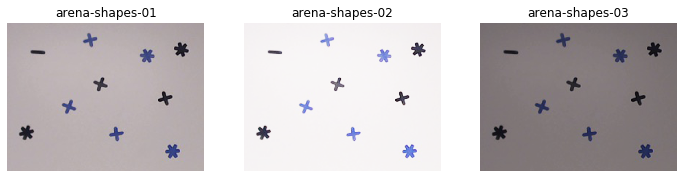

In [25]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [26]:
im0 = images[0]
im1 = images[1]
im2 = images[2]

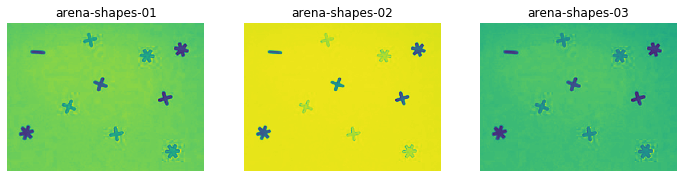

In [27]:
# go from pixel arrays [r, g, b] to b
im0_blue = np.array([[p[2] for p in r] for r in im0])
im1_blue = np.array([[p[2] for p in r] for r in im1])
im2_blue = np.array([[p[2] for p in r] for r in im2])

im_blues = [im0_blue, im1_blue, im2_blue]

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), im_blues, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

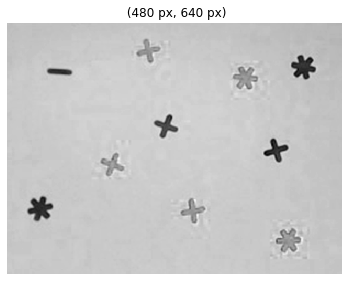

In [28]:
plotIm(im0_blue)

In [29]:
hist, bins = np.histogram(im2_blue, 256)

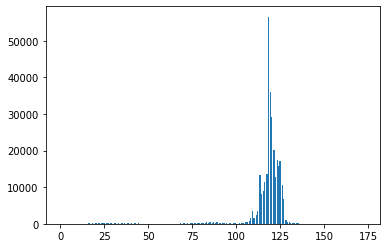

In [30]:
plt.bar(bins[1:], hist)
plt.show()

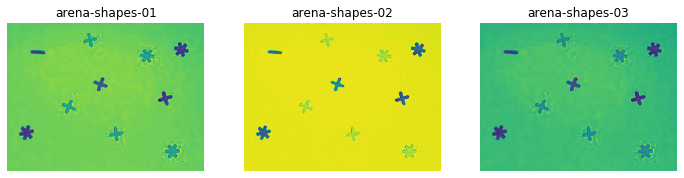

In [31]:
# go from pixel arrays [r, g, b] to b
i0b_s = stretchHist(im0_blue, 255)
i1b_s = stretchHist(im1_blue, 255)
i2b_s = stretchHist(im2_blue, 255)

ib_s = [i0b_s, i1b_s, i2b_s]

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ib_s, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

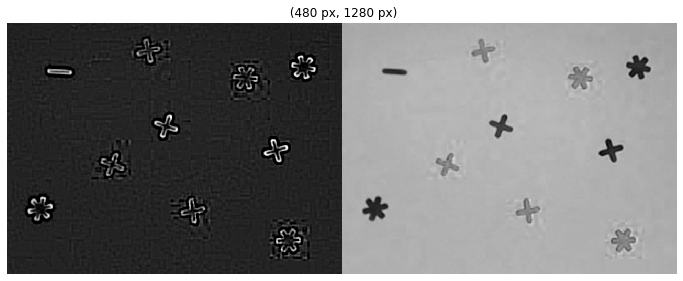

In [32]:
sigma = 2.25 ## Larger sigma = more noise reduction
kernel_size = 9 ## Larger kernel = better approximation
LoG_kernel = constructLoGKernel(sigma, kernel_size)

i0bs_LoG = cv2.filter2D(i2b_s, -1, LoG_kernel) 
plotImComp(i0bs_LoG, im0_blue)

# TRY NEW METHOD HERE

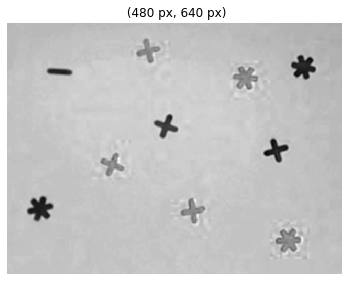

In [379]:
im = im2_blue ## or im1_blue, or im0_blue...
blurred = cv2.GaussianBlur(im, (5,5), 0)
plotIm(blurred)

### Separate bg from groups

In [380]:
d = 50
l = 3
u = 3

min_region_size = 1000
seeds = createIndexGrid(blurred.shape, d)
bg_regions, bg_visited_pixels = collectAllRegions(seeds, blurred, min_region_size, l, u, fn=neighbourInRelativeRange)

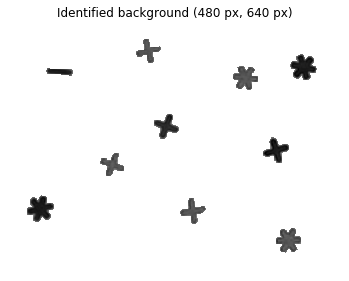

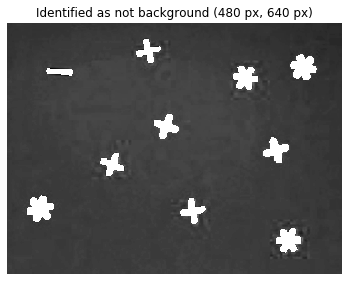

In [381]:
bg_idx = idxOfLargestList(regions)

all_indices = set([(i, j) for i in range(blurred.shape[0]) for j in range(blurred.shape[1])])
not_bg_indices = all_indices - set(regions[bg_idx])

visualizeIndices(im, regions[bg_idx], 'Identified background')
visualizeIndices(im, not_bg_indices, 'Identified as not background')

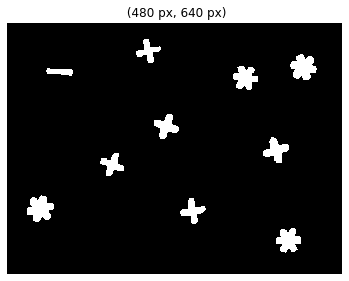

In [382]:
binary = im.copy()
for p in regions[0]: binary[p] = 0
for q in not_bg_indices: binary[q] = 255
plotIm(binary)

In [383]:
d = 2
l = 2
u = 2

min_region_size = 50 ## Assuming background is only area with > 1000 connex pixels
seeds = createIndexGrid(blurred.shape, d)
regions, visited_pixels = collectAllRegions(seeds, binary, min_region_size, l, u, fn=neighbourInRelativeRange)

In [384]:
bg_idx = idxOfLargestList(regions)

### Calculate mean value of your regions (except background)

In [385]:
means = [np.array([im[p] for p in r]).mean() for r in regions]
len(means)

11

In [386]:
import itertools
def allSubsetsOfList(s, illegal_idx, l=None, subs=[]):
    if l==None: l = len(s)
    if l:
        for sub in itertools.combinations(s, l):
            tp = list(sub)
            if not illegal_idx in tp: subs.append(tp)
        allSubsetsOfList(s, illegal_idx, l-1)
        
    return subs

In [387]:
possible_region_groups = allSubsetsOfList(range(len(means)), bg_idx)

### This solution only works for TWO different groups at the moment

In [388]:
lowest_std = float('inf')
lowest_std_indices_a = None
lowest_std_indices_b = None

for region_group in possible_region_groups:
    not_region_group = [j for j in range(len(means)) if j not in ([bg_idx]+region_group)]
    
    group_a = [means[i] for i in region_group]
    group_b = [means[j] for j in not_region_group]
    
    total_std = np.array(group_a).std() + np.array(group_b).std()
    if total_std < lowest_std:
        lowest_std = total_std
        lowest_std_indices_a = region_group
        lowest_std_indices_b = not_region_group

In [389]:
print(f'Identified {len(lowest_std_indices_a)} regions of color A and {len(lowest_std_indices_b)} regions of color B')

Identified 5 regions of color A and 5 regions of color B


### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

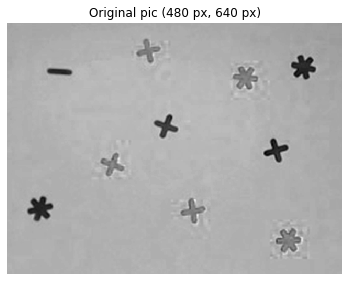

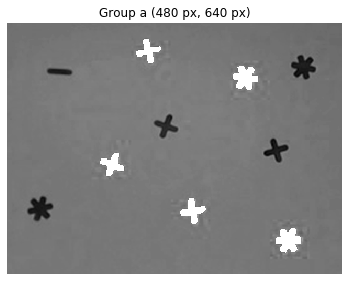

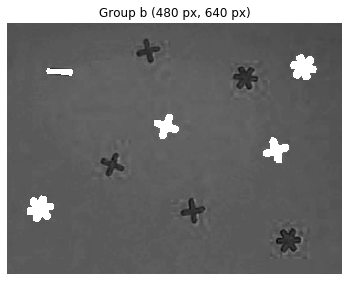

In [390]:
all_group_a_indices = []
for i in lowest_std_indices_a: all_group_a_indices += regions[i]

all_group_b_indices = []
for j in lowest_std_indices_b: all_group_b_indices += regions[j]
    
plotIm(im, 'Original pic')

visualizeIndices(im, all_group_a_indices, 'Group a')
visualizeIndices(im, all_group_b_indices, 'Group b')

In [366]:
print(f'Number of group a pixels: {len(all_group_a_indices)}')
print(f'Number of group b pixels: {len(all_group_b_indices)}')

Number of group a pixels: 5955
Number of group b pixels: 6472
